## Smooth aggregated hook by hook longline data

#### Summary
*  Input data are the aggregated rasters produced in the DataPrep.R section of the sdm-framework (https://gitlab.com/dfo-msea/sdm)
*  Choose size of neighbourhood you wish to smooth over
*  Smoothing extends presence cells over the chosen neighbourhood, but not past na values in input raster
*  Convert raster to points and export as shapefiles

In [295]:
# import necessary modules
import numpy as np # for array math
import rasterio # for reading and writing rasters and spatial indexing of rasters
import rasterio.plot # to plot rasters
import gdal # to build raster stats and pyramids
from matplotlib import pyplot as plt # for colourbar maps and histogram plot
import matplotlib.colors # for colour bins in raster map
from astropy.convolution import convolve # for smoothing
import glob # for listing files in a directory
from pathlib import Path # for handling file paths
import pandas as pd # for dataframe
import geopandas # for points

In [296]:
# Get raster list
raster_files = glob.glob("rasters/*.tif")

# Select size of neigbourhood for smoothing
size = 5

In [297]:
# Smooth fishing pressure across a neighbourhood
# Using a distance weighted focal sum

# Function to smooth/interpolate the point density raster
# Size is the number of cells in the square neighbourhood (recommend choosing odd values)
def calc_smooth(size, raster_file):

    # Load raster and get array and profile
    raster = rasterio.open(raster_file)
    array = raster.read(1)
    array[array==array.min()] = np.nan # low value  to na
    profile = raster.profile

    # Get proj info
    proj = raster.crs
    print('Raster projection: ' + str(proj.data))
    
    # Kernel for smoothing
    kernel = np.ones((size,size))
    
    # Convolution from astropy package to preserve na values
    smooth = convolve(array, kernel, normalize_kernel=False, boundary="extend", preserve_nan=True)
    
    # Any value greater than 0 should be a presence (1)
    smooth[smooth > 0] = 1
    
    # Write masked raster
    with rasterio.Env():
        # Write raster
        output_file = 'smoothed-rasters/' + Path(raster_file).stem + '_smoothed.tif'
        with rasterio.open(output_file, 'w', **profile) as dataset:
            dataset.write(smooth.astype(rasterio.float32), 1)
    # return
    return proj

#Calculate smoothed point density rasters
#Geotif output in rasters directory
for r in raster_files:
    proj = calc_smooth(size=size, raster_file=r)  

Raster projection: {'proj': 'aea', 'lat_0': 45, 'lon_0': -126, 'lat_1': 50, 'lat_2': 58.5, 'x_0': 1000000, 'y_0': 0, 'ellps': 'GRS80', 'towgs84': '0,0,0,0,0,0,0', 'units': 'm', 'no_defs': True}


/home/nephinj/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater


Raster projection: {'proj': 'aea', 'lat_0': 45, 'lon_0': -126, 'lat_1': 50, 'lat_2': 58.5, 'x_0': 1000000, 'y_0': 0, 'ellps': 'GRS80', 'towgs84': '0,0,0,0,0,0,0', 'units': 'm', 'no_defs': True}


In [298]:
# Get raster list
smooth_files = glob.glob("smoothed-rasters/*.tif")

In [299]:
# Build pyramids and calcualte stats for all rasters

# Loop through raster files
for r in smooth_files:
    # Set to 1 (read/write) mode to set pyramids and stats internally
    raster = gdal.Open(r, 1)
    gdal.SetConfigOption('COMPRESS_OVERVIEW', 'DEFLATE')
    # BUild pyramids for all resolutions
    raster.BuildOverviews("NEAREST", [2,4,8,16,32,64,128,256,512,1024])
    # Caluclate stats
    raster.GetRasterBand(1).GetStatistics(0,1)
    del raster

In [300]:
# Convert raster to points

# Empty lists to fill
rlist = []; xlist = []; ylist = []; zlist = []

# Open smoothed rasters
for r in range(len(smooth_files)):
    with rasterio.open(smooth_files[r]) as raster:
        # Read raster as array
        a = raster.read(1)
        # Array indices that are not nan
        ind = np.where(~np.isnan(a))
        
        # Which species
        name = Path(smooth_files[r]).stem 
        sp = name.split('_')[0]
                  
        # Add species name
        rlist.append(sp)

        # Loop through non-nan indices
        for i in range(0, len(ind[0])):
            # Get row and column index
            row = ind[0][i]
            col = ind[1][i]
            # Get xy values at index
            x, y = raster.xy(row,col)
            if r == 0: xlist.append(x)
            if r == 0: ylist.append(y)

            # Get raster value at index
            val = a[row,col]
            zlist.append(val)


In [301]:
# Convert xyz values to geopandas dataframe

# Create dictionary with raster values associated with species names as keys
zdicts = {}
start=0
end=len(xlist)
for i in rlist:
    zdicts[i] = zlist[start:end]
    start=end
    end=end+end

# Create geopandas using crs from original raster
gdf = geopandas.GeoDataFrame( pd.DataFrame(zdicts), crs=proj,
                             geometry=geopandas.points_from_xy(xlist, ylist) )
# View head
gdf.head(10)

# Write to shapefile
filename = 'shapefile/aggregated_smoothed_' + str(size) + 'cells.shp'
gdf.to_file(filename)

<AxesSubplot:>

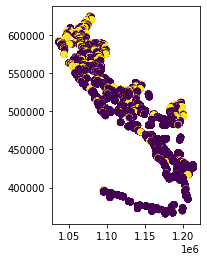

In [302]:
# Example plot
gdf.plot(column=rlist[0])